##  Practical Implementation - Convolutional Neural Network (CNN)

## 1. Important Information

The content of this notebook is based on the GSERM Summer School's "Deep Learning: Fundamentals and Applications" course of the University of St. Gallen and extended to showcase the use of the ML experiment tracking tool `Weigths & Biases`.

## 2. Setup of the Jupyter Notebook Environment

Similar to other labs, we need to import several Python libraries that facilitate data analysis and visualization. We will primarily use `PyTorch`, `NumPy`, `Scikit-learn`, `Matplotlib`, `Seaborn`, and a few utility libraries throughout this lab:

In [1]:
# import standard python libraries
import os, urllib, io
from datetime import datetime
import numpy as np

Import `Python` machine learning and deep learning libraries:

In [2]:
# import the PyTorch deep learning library
import torch, torchvision
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import random_split

Import `Scikit-learn` classification metrics:

In [3]:
# import sklearn classification evaluation library
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

Import `Matplotlib`, `Seaborn` and `PIL` data visualization libraries:

In [6]:
# import matplotlib, seaborn, and PIL data visualization library
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

Import `wandb` and log in to your W&B account:

In [ ]:
import wandb

wandb.login()  # Log in to your W&B account

Enable inline plotting with `Matplotlib`:

In [8]:
%matplotlib inline

Set a random `seed` value to obtain reproducible results:

In [9]:
# init deterministic seed (outputs always the same numbers)
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU

Google Colab provides free GPUs for running notebooks. However, if you execute this notebook as is, it will use your device's CPU. To run the lab on a GPU, go to `Runtime` > `Change runtime type` and set the Runtime type to `GPU` in the drop-down menu. Running this lab on a CPU is fine, but you will find that GPU computing is faster. *CUDA* indicates that the lab is being run on a GPU.

Enable GPU computing by setting the device flag and initializing a CUDA seed:

In [10]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
print('[LOG] notebook with {} computation enabled'.format(str(device)))

[LOG] notebook with cpu computation enabled


Let's determine if we have access to a GPU provided by environments such as `Google Colab`:

In [11]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


## 3. Dataset Download and Data Assessment

The **CIFAR-10 database** (**C**anadian **I**nstitute **F**or **A**dvanced **R**esearch) is a collection of images. The size of each image is 32 by 32 pixels. Specifically, it contains **60,000 color images**. The size of each image is 32 by 32 pixels. The collection of images encompasses 10 different classes: airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. Let's define the distinct classes for further analysis.

In [12]:
cifar10_classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Let's download the CIFAR-10 training (80%) and validation (10%) and test (10%) datasets and log them to W&B:

In [13]:
# Define the root and output directory for the CIFAR-10 dataset
root_dir = "data/cifar10"
output_dir = "data/cifar10_tensor"
os.makedirs(output_dir, exist_ok=True)

# Transform images into PyTorch tensors and normalize them (important for training)
transf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the full training dataset (50k images)
full_train = torchvision.datasets.CIFAR10(root=root_dir, train=True, transform=transf, download=True)

# Split data into training (40k images) and validation (10k images)
train_size = int(0.8 * len(full_train))  # 40,000
val_size = len(full_train) - train_size  # 10,000
train_data, val_data = random_split(full_train, [train_size, val_size])

# Load the test set (10k images)
test_data = torchvision.datasets.CIFAR10(root=root_dir, train=False, transform=transf, download=True)

# Save the dataset splits locally
torch.save(train_data, os.path.join(output_dir, "train_data.pt"))
torch.save(val_data, os.path.join(output_dir, "val_data.pt"))
torch.save(test_data, os.path.join(output_dir, "test_data.pt"))


# ====== Log the datasets as artifacts to W&B ======

# Initialize W&B run
wandb.init(project="CIFAR10-Experiment-WB", name="log-tensor-datasets")

# Log the dataset splits as artifacts
train_artifact = wandb.Artifact("cifar10-train-tensor", type="dataset")
train_artifact.add_file(os.path.join(output_dir, "train_data.pt"))
wandb.log_artifact(train_artifact)

val_artifact = wandb.Artifact("cifar10-val-tensor", type="dataset")
val_artifact.add_file(os.path.join(output_dir, "val_data.pt"))
wandb.log_artifact(val_artifact)

test_artifact = wandb.Artifact("cifar10-test-tensor", type="dataset")
test_artifact.add_file(os.path.join(output_dir, "test_data.pt"))
wandb.log_artifact(test_artifact)

wandb.finish() # Finish the W&B run

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Verify the volume of training, validation and test images downloaded:

In [14]:
print(f"Train: {len(train_data)} | Val: {len(val_data)} | Test: {len(test_data)}")

Train: 40000 | Val: 10000 | Test: 10000


Next, let's investigate a couple of the training images:

In [15]:
# set (random) image id
image_id = 1800

# retrieve image exhibiting the image id
train_data[image_id]

(tensor([[[-0.1373, -0.1686, -0.1451,  ..., -0.2627, -0.1843, -0.1922],
          [-0.2157, -0.2000, -0.2078,  ..., -0.2471, -0.2000, -0.2078],
          [-0.2627, -0.1686, -0.2078,  ..., -0.2157, -0.1451, -0.1451],
          ...,
          [ 0.1137,  0.0980,  0.0824,  ...,  0.0196,  0.0118,  0.1137],
          [ 0.0667,  0.0353,  0.0431,  ...,  0.0196,  0.0039,  0.0745],
          [ 0.0196, -0.0196,  0.0039,  ..., -0.2471, -0.2078, -0.1922]],
 
         [[ 0.0667,  0.0588,  0.0510,  ..., -0.0980, -0.0118, -0.0275],
          [-0.0039, -0.0039, -0.0353,  ..., -0.0824, -0.0353, -0.0667],
          [-0.0824, -0.0275, -0.0824,  ..., -0.0510,  0.0353,  0.0275],
          ...,
          [ 0.2941,  0.2706,  0.2627,  ...,  0.1843,  0.1922,  0.3098],
          [ 0.2549,  0.2235,  0.2392,  ...,  0.1686,  0.1686,  0.2549],
          [ 0.2157,  0.1686,  0.2000,  ..., -0.0980, -0.0588, -0.0118]],
 
         [[ 0.1059,  0.1137,  0.0824,  ..., -0.0667, -0.0196, -0.0196],
          [ 0.0196,  0.0588,

Ok, that doesn't seem easily interpretable ;) Let's first separate the image from its label information:

In [16]:
cifar10_train_image, cifar10_train_label = train_data[image_id]

Great, now we can visually inspect our sample image:

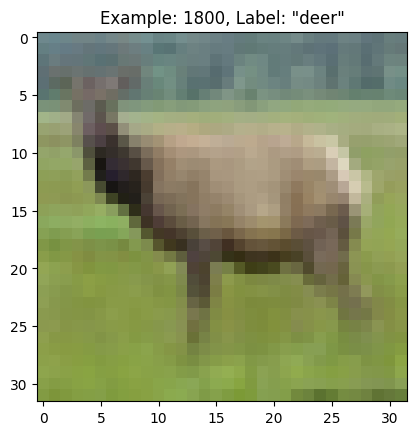

In [17]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title
plt.title('Example: {}, Label: "{}"'.format(str(image_id), str(cifar10_classes[cifar10_train_label])))

# un-normalize cifar 10 image sample
cifar10_train_image_plot = cifar10_train_image / 2.0 + 0.5

# plot 10 image sample
plt.imshow(trans(cifar10_train_image_plot))

## 4. Neural Network Implementation

In this section we, will implement the architecture of the **neural network** we aim to utilize to learn a model that is capable of classifying the **32x32 pixel** CIFAR 10 images according to the objects contained in each image. 

Please find the model implementation in the separate `CNN.py` file and the corresponding `CNN.yaml`.

## 5. Neural Network Model Training

In this section, we will train our neural network model (as implemented in the section above) using the transformed images. 

Specifically, we will apply Hyperparameter Optimization through so-called Sweeps in W&B. For that please:

1. Take a look at the CNN.yaml file with the different HPO parameter combinations spedified.
2. Visit the train_sweep.py script where the training process is specified.
3. Run the HPO with the command: `wandb sweep CNN.yaml` in the root of this directory (this starts the hyperparameter tuning)
4. Run the wandb agent command.
5. Follow the tuning process (different runs) on your W&B project dashboard. 
6. Once all runs are finished, filter the runs according to their validation loss (that's what we wanted to minimize). The run with the smallest validation loss is our best model. 
7. Update and log the parameters of the best model to W&B with the following code:


In [ ]:
wandb.init(project="CIFAR10-Experiment-WB", name="best-run-setup")

wandb.config.update({
    "learning_rate": 0.01,
    "optimizer": "SGD",
    "loss": "NLLLoss",
    "batch_size": 32,
    "epochs": 20
})
wandb.finish()

8. Now, go to the "Runs" dashboard of the W&B project and sort the runs acording to VAL_LOSS ascending. The top most run is our best run and by clicking on it and going to the Artifacts/Files you can find the BEST_CNN.pth file. 
9. Please write down the run_id and the exact artifact_name_contains variables in the code below and run the code below to download the best model into the /models/ direcory of this project.

In [44]:
# --- Configuration ---
run_id = "2m6jfq78"  #2m6jfq78 7wc4xy09
project_path = "emma-kozmer-university-of-st-gallen/CIFAR10-Experiment-WB/runs"
artifact_name_contains = "BEST_CNN:v30" 
download_dir = "models"

# --- Load Run from API ---
api = wandb.Api()
run = api.run(f"{project_path}/{run_id}")

print("\nRun Metadata:")
print(f"Run Name: {run.name}")
print(f"Config: {run.config}")
print(f"val_loss (from summary): {run.summary.get('val_loss')}\n")

# --- Locate and Download Artifact ---
for artifact in run.logged_artifacts():
    if artifact.type == "model" and artifact_name_contains in artifact.name:
        model_path = artifact.download(root=download_dir)
        print(f"Model downloaded to: {model_path}")
        break
else:
    print("No matching model artifact found in this run.")
    exit()


Run Metadata:
Run Name: good-sweep-7
Config: {'seed': 1234, 'optimizer': 'SGD', 'batch_size': 32, 'num_epochs': 20, 'learning_rate': 0.01}
val_loss (from summary): 1.0726522757603338



wandb:   1 of 1 files downloaded.  


Model downloaded to: models


10. Now, we are ready to evaluate the model. 

## 6. Neural Network Model Evaluation

For the evaluation our model, needs to be loaded from the local directory where we stored it in the previous step.

In [45]:
from CNN import CIFAR10Net

# Initialize model
best_model = CIFAR10Net()

# Load model weights from the local .pth file
model_path = "models/BEST_CNN.pth"
best_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Set model to evaluation mode
best_model.eval()

print("Model loaded successfully from models/BEST_CNN.pth")


Model loaded successfully from models/BEST_CNN.pth


To evaluate our trained model, we need to feed the CIFAR-10 images reserved for evaluation (the images that we didn't use as part of the training process) through the model. Therefore, let's define a corresponding PyTorch data loader that feeds the image tensors to our neural network.

We will now evaluate the trained model using the same mini-batch approach as we did when training the network and derive the mean negative log-likelihood loss of all mini-batches processed in an epoch:

In [46]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datetime import datetime

# Define the transform used during training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the test dataset from .pt file
test_data = torch.load("data/cifar10_tensor/test_data.pt", weights_only=False) 
test_loader = DataLoader(test_data, batch_size=10000, shuffle=False)

# Loss function
nll_loss = nn.NLLLoss()

# Evaluate
eval_mini_batch_losses = []

for images, labels in test_loader:
    output = best_model(images)
    loss = nll_loss(output, labels)
    eval_mini_batch_losses.append(loss.item())

eval_loss = np.mean(eval_mini_batch_losses)
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print(f"[LOG {now}] eval-loss: {eval_loss:.4f}")


[LOG 20250413-14:31:20] eval-loss: 1.0608


Great! The evaluation loss looks in line with our training loss. Let's now inspect a few sample predictions to get an impression of the model quality. We will again pick a random image from our evaluation dataset and retrieve its PyTorch tensor as well as the corresponding label:

In [47]:
# set (random) image id
image_id = 777

# retrieve image exhibiting the image id
cifar10_eval_image, cifar10_eval_label = test_data[image_id]

Let's now check the true class of the image we selected:

In [48]:
cifar10_classes[cifar10_eval_label]

'frog'

Okay, the randomly selected image should contain a two (2). Let's inspect the image accordingly:

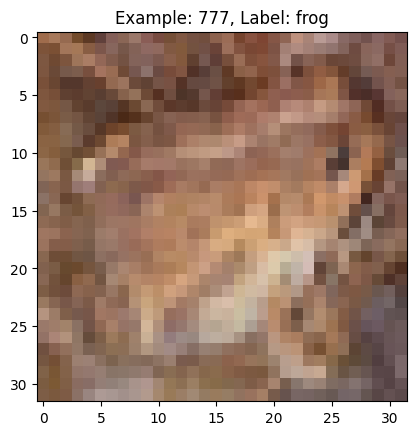

In [49]:
# define tensor to image transformation
trans = torchvision.transforms.ToPILImage()

# set image plot title
plt.title('Example: {}, Label: {}'.format(str(image_id), str(cifar10_classes[cifar10_eval_label])))

# un-normalize cifar 10 image sample
cifar10_eval_image_plot = cifar10_eval_image / 2.0 + 0.5

# plot cifar 10 image sample
plt.imshow(trans(cifar10_eval_image_plot))

Now, let's compare the true label with the prediction of our model:


In [50]:
best_model(cifar10_eval_image.unsqueeze(0))

tensor([[-8.4396, -9.3668, -4.8111, -1.7079, -3.6583, -2.4736, -0.3590, -6.4075,
         -8.5955, -9.6339]], grad_fn=<LogSoftmaxBackward0>)

We can even determine the likelihood of the most probable class:

In [51]:
cifar10_classes[torch.argmax(best_model(Variable(cifar10_eval_image.unsqueeze(0))), dim=1).item()]

'frog'

Let's now obtain the predictions for all the CIFAR-10 images in the evaluation data:

In [52]:
predictions = torch.argmax(best_model(next(iter(test_loader))[0]), dim=1)

Next, let's obtain the overall classification accuracy:

In [53]:
metrics.accuracy_score(test_data.targets, predictions.detach())

0.6334

Finally, let's also inspect the confusion matrix of the model predictions to determine the major sources of misclassification:

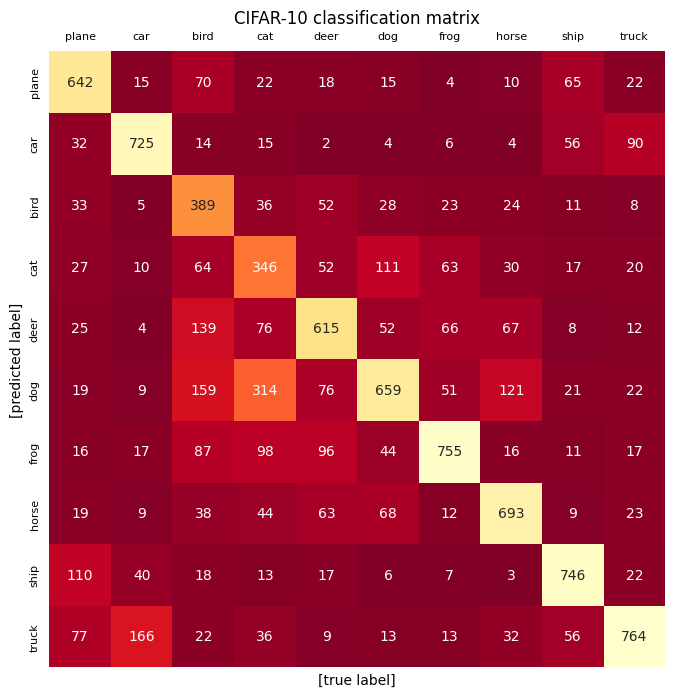

In [30]:
# determine classification matrix of the predicted and target classes
mat = confusion_matrix(test_data.targets, predictions.detach())

# initialize the plot and define size
plt.figure(figsize=(8, 8))

# plot corresponding confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='YlOrRd_r', xticklabels=cifar10_classes, yticklabels=cifar10_classes)
plt.tick_params(axis='both', which='major', labelsize=8, labelbottom = False, bottom=False, top = False, left = False, labeltop=True)

# set plot title
plt.title('CIFAR-10 classification matrix')

# set plot axis lables
plt.xlabel('[true label]')
plt.ylabel('[predicted label]');

Okay, we can easily see that our current model often confuses images of cats and dogs, as well as images of trucks and cars. This is not surprising since those image categories exhibit a high semantic and visual similarity.